In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive
!git clone https://github.com/antonsoo/customer-churn-prediction

/content/drive/MyDrive
Cloning into 'customer-churn-prediction'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 5 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (5/5), done.


In [4]:
%cd customer-churn-prediction
%mkdir data model src notebooks

In [5]:
!pip install pandas numpy scikit-learn xgboost lightgbm streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 67.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 73.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.7 MB/s eta 0:00:00


In [6]:
# --- Cell 1: Import Libraries and Mount Drive ---
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# --- Cell 2: Configuration and Constants ---
# Define paths, model parameters, etc.
DATA_DIR = '/content/drive/MyDrive/customer-churn-prediction/data' # Make sure this directory exists
MODEL_DIR = '/content/drive/MyDrive/customer-churn-prediction/model' # Make sure this directory exists
TRAIN_SCRIPT_PATH = '/content/drive/MyDrive/customer-churn-prediction/src/train.py'
APP_SCRIPT_PATH = '/content/drive/MyDrive/customer-churn-prediction/src/app.py'
NOTEBOOK_PATH = '/content/drive/MyDrive/customer-churn-prediction/notebooks/customer_churn_prediction.ipynb'

In [8]:
# --- Cell 3: Download the Dataset (if necessary) ---
# Use this cell to download the dataset from Kaggle or another source
# Example (Kaggle):
!kaggle datasets download -d blastchar/telco-customer-churn -p {DATA_DIR}
!unzip {DATA_DIR}/telco-customer-churn.zip -d {DATA_DIR}

Dataset URL: https://www.kaggle.com/datasets/blastchar/telco-customer-churn
License(s): copyright-authors
100% 172k/172k [00:00<00:00, 678kB/s]
100% 172k/172k [00:00<00:00, 672kB/s]
Archive:  /content/drive/MyDrive/customer-churn-prediction/data/telco-customer-churn.zip
  inflating: /content/drive/MyDrive/customer-churn-prediction/data/WA_Fn-UseC_-Telco-Customer-Churn.csv  


In [21]:
%%writefile '/content/drive/MyDrive/customer-churn-prediction/data/STEPS_TO_DOWNLOAD_DATA.MD'
!kaggle datasets download -d blastchar/telco-customer-churn -p {DATA_DIR}
!unzip {DATA_DIR}/telco-customer-churn.zip -d {DATA_DIR}

Writing /content/drive/MyDrive/customer-churn-prediction/data/STEPS_TO_DOWNLOAD_DATA.MD


In [9]:
# --- Cell 4: Data Loading and Preprocessing ---
# Load data
data = pd.read_csv(os.path.join(DATA_DIR, "WA_Fn-UseC_-Telco-Customer-Churn.csv")) # Update with the name of the dataset csv file

# Basic Cleaning
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
data['TotalCharges'].fillna(data['TotalCharges'].median(), inplace=True)

# Feature Engineering (Example)
# data['TenureInMonths'] = data['tenure'] * 12  # Example: If you have tenure in years

# Separate features (X) and target (y)
X = data.drop(['customerID', 'Churn'], axis=1)
y = data['Churn']

# Encode target variable
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Identify numerical and categorical features
numerical_features = X.select_dtypes(include=['number']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Create a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Fit and transform the training data
X_train_processed = preprocessor.fit_transform(X_train)

# Transform the validation and test data
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

<ipython-input-9-f584b3ecf7a6>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['TotalCharges'].fillna(data['TotalCharges'].median(), inplace=True)


In [12]:
# --- Cell 5: Model Training ---
# Logistic Regression
log_reg = LogisticRegression(random_state=42, max_iter=100000)
log_reg.fit(X_train_processed, y_train)
y_val_pred_log_reg = log_reg.predict(X_val_processed)

print("Logistic Regression Validation Accuracy:", accuracy_score(y_val, y_val_pred_log_reg))
print(classification_report(y_val, y_val_pred_log_reg))

# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_processed, y_train)
y_val_pred_rf = rf_model.predict(X_val_processed)

print("Random Forest Validation Accuracy:", accuracy_score(y_val, y_val_pred_rf))
print(classification_report(y_val, y_val_pred_rf))

# XGBoost
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_processed, y_train)
y_val_pred_xgb = xgb_model.predict(X_val_processed)

print("XGBoost Validation Accuracy:", accuracy_score(y_val, y_val_pred_xgb))
print(classification_report(y_val, y_val_pred_xgb))

Logistic Regression Validation Accuracy: 0.8162878787878788
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       778
           1       0.68      0.58      0.62       278

    accuracy                           0.82      1056
   macro avg       0.77      0.74      0.75      1056
weighted avg       0.81      0.82      0.81      1056

Random Forest Validation Accuracy: 0.7973484848484849
              precision    recall  f1-score   support

           0       0.83      0.92      0.87       778
           1       0.66      0.47      0.55       278

    accuracy                           0.80      1056
   macro avg       0.75      0.69      0.71      1056
weighted avg       0.78      0.80      0.78      1056



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:18:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Validation Accuracy: 0.7964015151515151
              precision    recall  f1-score   support

           0       0.84      0.89      0.87       778
           1       0.64      0.53      0.58       278

    accuracy                           0.80      1056
   macro avg       0.74      0.71      0.72      1056
weighted avg       0.79      0.80      0.79      1056



Test Accuracy: 0.7861873226111636
              precision    recall  f1-score   support

           0       0.82      0.89      0.86       761
           1       0.65      0.51      0.57       296

    accuracy                           0.79      1057
   macro avg       0.74      0.70      0.71      1057
weighted avg       0.78      0.79      0.78      1057

Confusion Matrix:
 [[680  81]
 [145 151]]


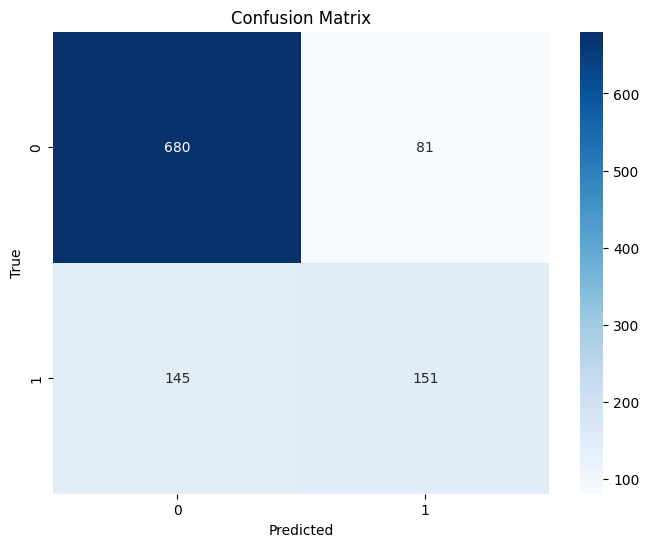

In [13]:
# --- Cell 6: Model Evaluation ---
# Assuming XGBoost is your best model
y_test_pred = xgb_model.predict(X_test_processed)

print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:\n", cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [14]:
# --- Cell 7: Save Model and Preprocessor ---
# Save the model
joblib.dump(xgb_model, os.path.join(MODEL_DIR, 'churn_prediction_model.pkl'))

# Save the preprocessor
joblib.dump(preprocessor, os.path.join(MODEL_DIR, 'preprocessor.pkl'))

['/content/drive/MyDrive/customer-churn-prediction/model/preprocessor.pkl']

In [18]:
# --- Cell 8: Create train.py (Optional) ---
%%writefile {TRAIN_SCRIPT_PATH}
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

# Configuration (You can adjust these as needed)
DATA_DIR = 'data'
MODEL_DIR = 'model'
TRAIN_SCRIPT_PATH = 'src/train.py'
APP_SCRIPT_PATH = 'src/app.py'
NOTEBOOK_PATH = 'notebooks/customer_churn_prediction.ipynb'

# --- Data Loading and Preprocessing ---
def load_and_preprocess_data(data_dir):
    data = pd.read_csv(os.path.join(data_dir, "WA_Fn-UseC_-Telco-Customer-Churn.csv"))

    # Basic Cleaning
    data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
    data['TotalCharges'].fillna(data['TotalCharges'].median(), inplace=True)

    # Feature Engineering (Example)
    # data['TenureInMonths'] = data['tenure'] * 12  # Example: If you have tenure in years

    # Separate features (X) and target (y)
    X = data.drop(['customerID', 'Churn'], axis=1)
    y = data['Churn']

    # Encode target variable
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)

    # Split data
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    # Identify numerical and categorical features
    numerical_features = X.select_dtypes(include=['number']).columns
    categorical_features = X.select_dtypes(include=['object']).columns

    # Create a column transformer for preprocessing
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ])

    # Fit and transform the training data
    X_train_processed = preprocessor.fit_transform(X_train)

    # Transform the validation and test data
    X_val_processed = preprocessor.transform(X_val)
    X_test_processed = preprocessor.transform(X_test)

    return X_train_processed, X_val_processed, X_test_processed, y_train, y_val, y_test, preprocessor

# --- Model Training ---
def train_model(X_train, y_train, X_val, y_val):
    # Logistic Regression
    log_reg = LogisticRegression(random_state=42, max_iter=1000)
    log_reg.fit(X_train, y_train)
    y_val_pred_log_reg = log_reg.predict(X_val)

    print("Logistic Regression Validation Accuracy:", accuracy_score(y_val, y_val_pred_log_reg))
    print(classification_report(y_val, y_val_pred_log_reg))

    # Random Forest
    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X_train, y_train)
    y_val_pred_rf = rf_model.predict(X_val)

    print("Random Forest Validation Accuracy:", accuracy_score(y_val, y_val_pred_rf))
    print(classification_report(y_val, y_val_pred_rf))

    # XGBoost
    xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
    xgb_model.fit(X_train, y_train)
    y_val_pred_xgb = xgb_model.predict(X_val)

    print("XGBoost Validation Accuracy:", accuracy_score(y_val, y_val_pred_xgb))
    print(classification_report(y_val, y_val_pred_xgb))

    return log_reg, rf_model, xgb_model

# --- Model Evaluation ---
def evaluate_model(model, X_test, y_test):
    y_test_pred = model.predict(X_test)

    print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
    print(classification_report(y_test, y_test_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_test_pred)
    print("Confusion Matrix:\n", cm)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# --- Main Function ---
def main():
    X_train_processed, X_val_processed, X_test_processed, y_train, y_val, y_test, preprocessor = load_and_preprocess_data(DATA_DIR)
    log_reg, rf_model, xgb_model = train_model(X_train_processed, y_train, X_val_processed, y_val)

    # Choose the best model based on validation performance
    best_model = xgb_model  # Replace with your chosen model

    evaluate_model(best_model, X_test_processed, y_test)

    # Save the model and preprocessor
    joblib.dump(best_model, os.path.join(MODEL_DIR, 'churn_prediction_model.pkl'))
    joblib.dump(preprocessor, os.path.join(MODEL_DIR, 'preprocessor.pkl'))

if __name__ == "__main__":
    main()

Writing /content/drive/MyDrive/customer-churn-prediction/src/train.py


In [ ]:
# --- Cell 9: Create app.py (Streamlit App) ---
%%writefile /content/drive/MyDrive/customer-churn-prediction/src/app.py
# Paste the entire content of your Streamlit app (app.py) here
import streamlit as st
import pandas as pd
import joblib
import os

# Set the absolute path to the directory where models are stored
model_dir = "/content/drive/MyDrive/customer-churn-prediction/model"  # Update this to your actual path

# Load the trained model and preprocessor
try:
    model = joblib.load(os.path.join(model_dir, 'churn_prediction_model.pkl'))
    preprocessor = joblib.load(os.path.join(model_dir, 'preprocessor.pkl'))
except Exception as e:
    st.error(f"Error loading the model: {e}")
    st.stop()

# Function to preprocess input data
def preprocess_input(data, preprocessor):
    df = pd.DataFrame([data])
    df_processed = preprocessor.transform(df)
    return df_processed

# Streamlit app
st.title("Customer Churn Prediction App")
st.write("""
Enter customer information to predict churn.
""")

# Input form
gender = st.selectbox("Gender", ["Male", "Female"])
senior_citizen = st.selectbox("Senior Citizen", ["No", "Yes"])
partner = st.selectbox("Partner", ["No", "Yes"])
dependents = st.selectbox("Dependents", ["No", "Yes"])
tenure = st.slider("Tenure (months)", 0, 72, 1)
phone_service = st.selectbox("Phone Service", ["No", "Yes"])
multiple_lines = st.selectbox("Multiple Lines", ["No", "Yes", "No phone service"])
online_security = st.selectbox("Online Security", ["No", "Yes", "No internet service"])
online_backup = st.selectbox("Online Backup", ["No", "Yes", "No internet service"])
device_protection = st.selectbox("Device Protection", ["No", "Yes", "No internet service"])
tech_support = st.selectbox("Tech Support", ["No", "Yes", "No internet service"])
streaming_tv = st.selectbox("Streaming TV", ["No", "Yes", "No internet service"])
streaming_movies = st.selectbox("Streaming Movies", ["No", "Yes", "No internet service"])
contract = st.selectbox("Contract", ["Month-to-month", "One year", "Two year"])
paperless_billing = st.selectbox("Paperless Billing", ["No", "Yes"])
payment_method = st.selectbox("Payment Method", ["Electronic check", "Mailed check", "Bank transfer (automatic)", "Credit card (automatic)"])
monthly_charges = st.number_input("Monthly Charges", 0.00, 200.00, 50.00)
total_charges = st.number_input("Total Charges", 0.00, 10000.00, 1000.00)
internet_service = st.selectbox("Internet Service", ["DSL", "Fiber optic", "No"])

# Convert input to a dictionary
input_data = {
    "gender": gender,
    "SeniorCitizen": 1 if senior_citizen == "Yes" else 0,
    "Partner": partner,
    "Dependents": dependents,
    "tenure": tenure,
    "PhoneService": phone_service,
    "MultipleLines": multiple_lines,
    "OnlineSecurity": online_security,
    "OnlineBackup": online_backup,
    "DeviceProtection": device_protection,
    "TechSupport": tech_support,
    "StreamingTV": streaming_tv,
    "StreamingMovies": streaming_movies,
    "Contract": contract,
    "PaperlessBilling": paperless_billing,
    "PaymentMethod": payment_method,
    "MonthlyCharges": monthly_charges,
    "TotalCharges": total_charges,
    "InternetService": internet_service
}

# Prediction button
if st.button("Predict Churn"):
    try:
        # Preprocess input data
        input_data_processed = preprocess_input(input_data, preprocessor)

        # Make prediction
        prediction = model.predict(input_data_processed)
        probability = model.predict_proba(input_data_processed)

        # Display result
        if prediction[0] == 1:
            st.warning("This customer is likely to churn.")
            st.write(f"Churn Probability: {probability[0][1]:.2f}")
        else:
            st.success("This customer is likely to stay.")
            st.write(f"Churn Probability: {probability[0][0]:.2f}")

    except Exception as e:
        st.error(f"An error occurred during prediction: {e}")

In [ ]:
!pip install flask

In [ ]:
# --- Cell 10: Test Streamlit App Locally (with Enhanced Debugging and Thread Management) ---
import threading
import subprocess
import time
import re
from pyngrok import ngrok, conf
import os
import sys
import yaml
import requests

# Set your ngrok auth token here
NGROK_AUTH_TOKEN = "YOUR NGROK TOKEN HERE"  # Replace with your actual token

# Define APP_SCRIPT_PATH (Make sure this is correct!)
APP_SCRIPT_PATH = "/content/drive/MyDrive/customer-churn-prediction/src/app.py"  # Update this!

# Ensure pyngrok is installed
try:
    import pyngrok
except ImportError:
    print("Installing pyngrok...")
    !pip install pyngrok
    import pyngrok

# Function to run Streamlit (unchanged from before)
# ... (The run_streamlit function remains the same) ...

# Function to run ngrok (modified for more verbose output)
def run_ngrok():
    try:
        time.sleep(15)  # Allow Flask server to start

        print("Starting ngrok...")

        # Set ngrok authentication token using pyngrok's conf module
        print("Setting ngrok auth token...")
        conf.get_default().auth_token = NGROK_AUTH_TOKEN
        # Tell ngrok to use the configuration file
        conf.get_default().config_path = ngrok.conf.get_default().config_path

        public_url = ngrok.connect(8502)
        print("Public URL:", public_url)

        # Extract and print the ngrok URL using regex
        match = re.search(r"\"(https://.*\.ngrok\.io)\"", str(public_url))
        if match:
            print("Ngrok URL:", match.group(1))
        else:
            print("Failed to extract ngrok URL. Check the ngrok output for details.")

    except Exception as e:
        print(f"Error running ngrok: {e}")

# Create and start threads
streamlit_thread = threading.Thread(target=run_streamlit)
ngrok_thread = threading.Thread(target=run_ngrok)

streamlit_thread.start()
ngrok_thread.start()

# --- Additional Debugging: Check Flask Server ---
time.sleep(20)  # Wait for Flask to start

try:
    response = requests.get("http://127.0.0.1:8502")
    response.raise_for_status()  # Raise an exception for bad status codes
    print("Flask server is accessible at http://127.0.0.1:8502")
    print("Flask response:", response.text)
except requests.exceptions.ConnectionError as e:
    print(f"Error accessing Flask server: {e}")
    print("Please check the Flask server logs for any errors.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

In [ ]:
# --- Cell 11 (and others below): Commit and Push to GitHub ---
#%cd /content/drive/MyDrive/customer-churn-prediction

In [ ]:
!git config --global user.email "your GitHub email"
!git config --global user.name "your GitHub name"

In [ ]:
!echo "*.gsheet" >> .gitignore
!echo ".config/" >> .gitignore
!git add .gitignore
!git commit -m "Add .gitignore to exclude unsupported files"

In [ ]:
!rm -rf .git  # Remove the current Git configuration
!git init     # Initialize Git in this folder
!git remote add origin https://github.com/<YourGitHubProfileName>/customer-churn-prediction.git

In [43]:
%cd /content/drive/MyDrive/customer-churn-prediction

/content/drive/MyDrive/customer-churn-prediction


In [44]:
!git reset

In [ ]:
!rm -rf .git  # Remove the current Git configuration
!git init     # Initialize Git in this folder
!git remote add origin https://github.com/antonsoo/customer-churn-prediction.git

In [46]:
!git add .

In [ ]:
!git add .
!git commit -m "Initial commit for customer-churn-prediction"

In [49]:
!git branch -M main

In [ ]:
!git push -u origin main

In [51]:
!git remote set-url origin https://<YourGitHubProfileName>:<Your GitHub API Pass-Key>@github.com/<YourGitHubProfileName>/customer-churn-prediction.git

In [ ]:
!git push -u origin main